In [1]:
%pylab inline
import sklearn
import sklearn.mixture

Populating the interactive namespace from numpy and matplotlib


['09', '10', '11', '12', '13', '14', '15']


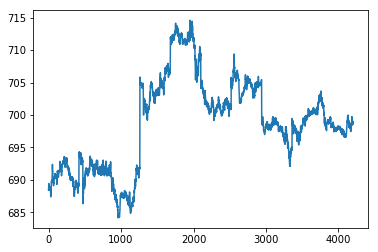

In [9]:
L = []
Good = map(str, range(9,16)) # od 9 do 15
Good[0] = '09'
print Good
for ff in open('OrderBookSnapshots.csv'):
    pre, tail = ff.split('BID')
    if pre.split()[1][:2] not in Good:
        continue
    mid, post = tail.split('ASK')
    mid = map(float, mid.split())
    mid = array(zip(mid[::2], mid[1::2]))
    post = map(float, post.split())
    post = array(zip(post[::2], post[1::2]))
    L.append((mid,post))
L = array(L) # czyste dane
P = array(map(lambda x : (x[0].max(axis=0)[0]+x[1].min(axis=0)[0])/2,L)) # P to lista cen
plot(P)
dif = (P[:-1]-P[1:])
dif = dif.reshape(-1,1) # różnice cen

In [12]:
def X1(D):
    return array(([D[0][-2], D[0][-1],D[1][0], D[1][1]])).reshape((8))

X1 = array(map(X1,L[:-1]))
n,d = X1.shape
A1 = zeros((n,3))

A1[(dif>0.5).reshape(n), 0] = 1
A1[((dif<=0.5)*(dif>=-0.5)).reshape(n), 1] = 1
A1[(dif<-0.5).reshape(n), 2] = 1

save('X1', X1)
save('A1', A)